In [1]:
import sys  
import numpy as np
import pandas as pd
from scipy.stats import cauchy

import matplotlib.pyplot as plt
from matplotlib import cm 
from mpl_toolkits.mplot3d import Axes3D 

sys.path.insert(0, './utils')
from utils.BenchmarkFunctions import Ackley, DeJong3, DeJong5, Michalewicz, Rastrigin, Schwefel, Sphere, Griewank, Rosenbrock

sys.path.insert(0, './ge')
from ge import *

# Housekeeping

In [2]:
populationSize = 40
numGenerations = 1000
numDimensions = 20
sphere = Sphere(numDimensions=numDimensions)
schwefel= Schwefel(numDimensions=numDimensions)

## Sphere vs Schwefel

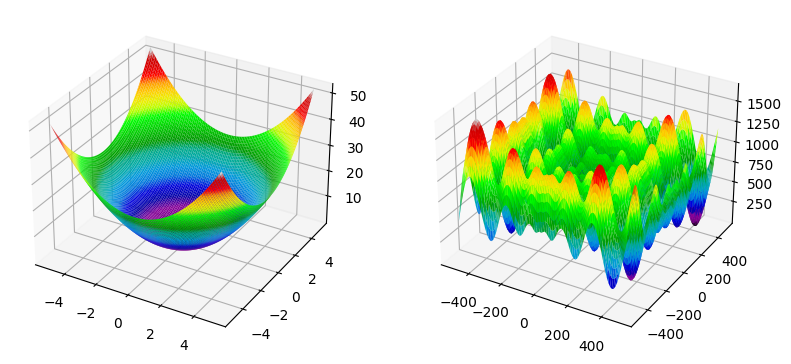

In [6]:
fig = plt.figure(figsize=plt.figaspect(0.5)) 

#Sphere
X_Sphere = np.linspace(-5.12, 5.12, 100)     
Y_Sphere = np.linspace(-5.12, 5.12, 100)     
X_Sphere, Y_Sphere = np.meshgrid(X_Sphere, Y_Sphere) 
Z_Sphere = X_Sphere ** 2 + Y_Sphere ** 2
ax_Sphere = fig.add_subplot(1, 2, 1, projection='3d')
ax_Sphere.plot_surface(X_Sphere, Y_Sphere, Z_Sphere, rstride=1, cstride=1,
  cmap=cm.nipy_spectral, linewidth=0.08,
  antialiased=True) 


#Schwefel
X_Schwefel = np.linspace(-500, 500, 100)     
Y_Schwefel = np.linspace(-500, 500, 100)     
X_Schwefel, Y_Schwefel = np.meshgrid(X_Schwefel, Y_Schwefel) 
Z_Schwefel = 418.9829 * 2 - ( (X_Schwefel * np.sin( np.sqrt( np.abs( X_Schwefel )))) + (Y_Schwefel * np.sin( np.sqrt( np.abs( Y_Schwefel )))))
ax_Schwefel = fig.add_subplot(1, 2, 2, projection='3d')
ax_Schwefel.plot_surface(X_Schwefel, Y_Schwefel, Z_Schwefel, rstride=1, cstride=1,
  cmap=cm.nipy_spectral, linewidth=0.08,
  antialiased=True)  
plt.show()

# Implementação do PSO 

PSO é um algoritmo relativamente simples. Existe uma população de agentes (particulas) que passa por um processo interativo (gerações) em que, a cada geração, todas as particulas atualizam suas posições (update):

In [7]:
def PSO(agentImpl, fitnessFunction, numGenerations, ndims, populationSize, options={}): 
    bounds = fitnessFunction.bounds()
    generations = []
    particles = [agentImpl(fitnessFunction, bounds.min, bounds.max, ndims, options) for i in range(populationSize)]
    best = min(particles, key = lambda p : p.fitness)
    for _ in range(numGenerations):
        for p in particles:
            p.update(best)
        best = min(particles, key = lambda p : p.fitness)
        generations.append(best.fitness)
    return {
            "best": best,
            "generations": generations
    } 

Seguindo esta estrutura base, a implementação da particula pode variar consoante a estratégia utilizada para a atualização da posição no espaço de procura....

## PSO Canônico

In [8]:
class Particle:
    def __init__(self, 
                 fitnessFunction, 
                 lowerBound, 
                 upperBound, 
                 nDims, 
                 options
                 ):
        self.fitnessFunction = fitnessFunction
        self.minval = lowerBound
        self.maxval = upperBound
        self.ndims = nDims
        self.inertiaFactor = options["inertiaFactor"] if "inertiaFactor" in options else .729
        self.selfConfidence = options["selfConfidence"] if "selfConfidence" in options else 1.49445
        self.swarmConfidence = options["swarmConfidence"] if "swarmConfidence" in options else 1.49445
        self.speed = np.array([0.0] * self.ndims)
        self.pos = np.random.uniform(low=self.minval, high = self.maxval, size = self.ndims)
        self.best = self.pos
        self.fitness = fitnessFunction.evaluate(self.pos)
     
    def update(self, best):
        self.speed = (
             self.inertiaFactor * self.speed + 
             self.selfConfidence * np.random.rand(self.ndims) * (self.best - self.pos) + 
             self.swarmConfidence * np.random.rand(self.ndims) * (best.best - self.pos)
        )
        self.pos = np.clip(self.pos + self.speed, self.minval, self.maxval)
        fit = self.fitnessFunction.evaluate(self.pos)
        if(fit < self.fitness): 
            self.fitness = fit
            self.best = self.pos

### Resultados do PSO Canônico para o Sphere

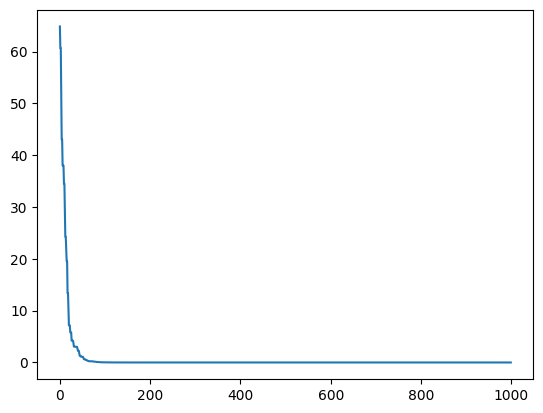

In [9]:
sphereCPSO = PSO(Particle, sphere, numGenerations, numDimensions, populationSize)
plt.plot(sphereCPSO["generations"])
plt.show()

### Resultados do PSO Canônico para o Schwefel

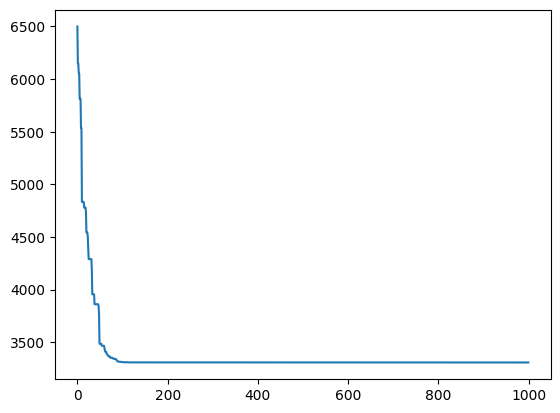

In [10]:
schwefelCPSO = PSO(Particle, schwefel, numGenerations, numDimensions, populationSize)
plt.plot(schwefelCPSO["generations"])
plt.show()

## Barebones PSO

In [11]:
class BBParticle:
    def __init__(self, fitnessFunction, lowerBound, upperBound, nDims, options):
        self.fitnessFunction = fitnessFunction
        self.minval = lowerBound
        self.maxval = upperBound
        self.ndims = nDims
        self.pos = np.random.uniform(low=self.minval, high = self.maxval, size = self.ndims)
        self.best = self.pos
        self.fitness = fitnessFunction.evaluate(self.pos)
     
    def update(self, best):
        posMean = np.add(self.best, best.best) / 2
        posSd = np.abs(np.subtract(self.best, best.best))
        self.pos = np.clip(np.random.normal(posMean, posSd)  , self.minval, self.maxval)
        fit = self.fitnessFunction.evaluate(self.pos)
        if(fit < self.fitness): 
            self.fitness = fit
            self.best = self.pos

### Resultados do BB vs PSO para o Sphere

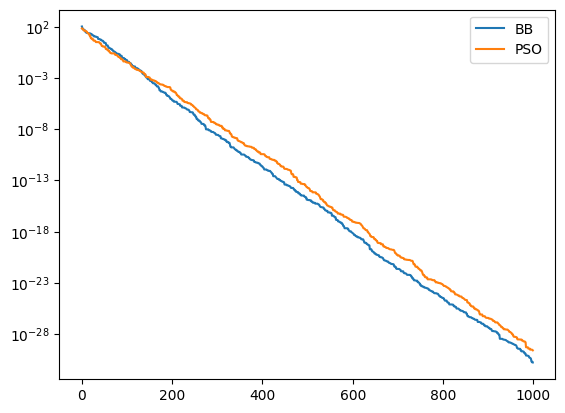

In [12]:
sphereBB = PSO(BBParticle, sphere, numGenerations, numDimensions, populationSize)
plt.plot(sphereBB["generations"], label="BB")
plt.plot(sphereCPSO["generations"], label="PSO")
plt.legend(["BB", "PSO"], loc='upper right')
plt.yscale('log')
plt.show()

In [13]:
df = pd.DataFrame({
  "PSO": [sphereCPSO["best"].fitness],
  "BB": [sphereBB["best"].fitness],
})
print(df) 

            PSO            BB
0  2.589027e-30  1.689390e-31


### Resultados do BB vs PSO para o Schwefel

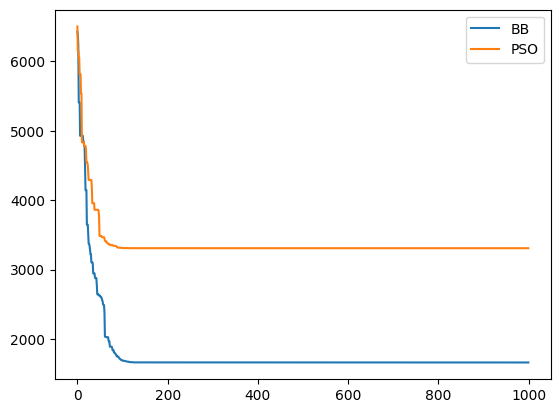

In [14]:
schwefelBB = PSO(BBParticle, schwefel, numGenerations, numDimensions, populationSize)
plt.plot(schwefelBB["generations"], label="BB")
plt.plot(schwefelCPSO["generations"], label="PSO")
plt.legend(["BB", "PSO"], loc='upper right')
plt.show()

In [15]:
df = pd.DataFrame({
  "PSO": [schwefelCPSO["best"].fitness],
  "BB": [schwefelBB["best"].fitness], 
})
print(df) 

           PSO           BB
0  3308.522831  1664.205177


In [16]:
grammar = """
<expr> ::= <canonicalPso>

<canonicalPso> ::= PSO(Particle, fitnessFunc, numGenerations, numDimensions, <populationSize>,  {"inertiaFactor":<inertiaFactor>, "selfConfidence":<selfConfidence>, "swarmConfidence":<swarmConfidence>})
 
<inertiaFactor> ::= 0.<int><int> | 1

<selfConfidence> ::= 0.<int><int> | 1.<int><int> | 2

<swarmConfidence> ::= 0.<int><int> | 1.<int><int> | 2

<populationSize> ::= 10 | 20 | 30 | 40 | 50 | 60 | 70 | 80 | 90 | 100

<int> ::= 0 | 1 | 2 | 3 | 4 | 5 | 6 | 7 | 8 | 9
"""

In [17]:
def siSphere(phenotype):
    fitnessFunc = sphere
    res = eval(phenotype)
    return res["best"].fitness
    
optPSOSphere = GE(
    grammar=grammar,
    fitnessFunction=siSphere, 
    populationSize=50, 
    numGenerations=50, 
    mutationProbability=0.1, 
    crossoverProbability=0.5, 
    genotypeLength=10
).evolve("<expr>")

df = pd.DataFrame({
  "PSO": [sphereCPSO["best"].fitness],
  "BB": [sphereBB["best"].fitness],
  "PSO OPT": [optPSOSphere[0].fitness],
})
print(df) 

            PSO            BB       PSO OPT
0  2.589027e-30  1.689390e-31  3.144204e-41


In [18]:
print(optPSOSphere[0].phenotype)

PSO(Particle, fitnessFunc, numGenerations, numDimensions, 100,  {"inertiaFactor":0.55, "selfConfidence":0.44, "swarmConfidence":2})


In [19]:
def siSchwefel(phenotype):
    fitnessFunc = schwefel
    res = eval(phenotype)
    return res["best"].fitness
    
optPSOSchwefel = GE(
    grammar=grammar,
    fitnessFunction=siSchwefel, 
    populationSize=50, 
    numGenerations=50, 
    mutationProbability=0.1, 
    crossoverProbability=0.5, 
    genotypeLength=10
).evolve("<expr>")

df = pd.DataFrame({
  "PSO": [schwefelCPSO["best"].fitness],
  "BB": [schwefelBB["best"].fitness],
  "PSO OPT": [optPSOSchwefel[0].fitness],
})
print(df) 

           PSO           BB      PSO OPT
0  3308.522831  1664.205177  1188.934779


In [20]:
print(optPSOSchwefel[0].phenotype)

PSO(Particle, fitnessFunc, numGenerations, numDimensions, 90,  {"inertiaFactor":0.77, "selfConfidence":0.66, "swarmConfidence":2})


In [21]:
autoGrammar = """
<expr> ::=  <bbPso> | <canonicalPso>

<bbPso> ::= PSO(BBParticle, fitnessFunc, numGenerations, numDimensions, <populationSize>)

<canonicalPso> ::= PSO(Particle, fitnessFunc, numGenerations, numDimensions, <populationSize>,  {"inertiaFactor":<inertiaFactor>, "selfConfidence":<selfConfidence>, "swarmConfidence":<swarmConfidence>})
 
<inertiaFactor> ::= 0.<int><int> | 1

<selfConfidence> ::= 0.<int><int> | 1.<int><int> | 2

<swarmConfidence> ::= 0.<int><int> | 1.<int><int> | 2

<populationSize> ::= 10 | 20 | 30 | 40 | 50 | 60 | 70 | 80 | 90 | 100

<int> ::= 0 | 1 | 2 | 3 | 4 | 5 | 6 | 7 | 8 | 9
"""

In [22]:
optPSOBBSchwefel = GE(
    grammar=autoGrammar,
    fitnessFunction=siSchwefel, 
    populationSize=50, 
    numGenerations=50, 
    mutationProbability=0.1, 
    crossoverProbability=0.5, 
    genotypeLength=10
).evolve("<expr>")

df = pd.DataFrame({
  "PSO": [schwefelCPSO["best"].fitness],
  "BB": [schwefelBB["best"].fitness],
  "AUTO": [optPSOBBSchwefel[0].fitness],
})
print(df) 

           PSO           BB         AUTO
0  3308.522831  1664.205177  1428.845567


In [23]:
print(optPSOBBSchwefel[0].phenotype)

PSO(BBParticle, fitnessFunc, numGenerations, numDimensions, 100)


## Cauchy PSO

In [24]:
class CauchyParticle:
    def __init__(self, fitnessFunction, lowerBound, upperBound, nDims, options):
        self.fitnessFunction = fitnessFunction
        self.minval = lowerBound
        self.maxval = upperBound
        self.ndims = nDims
        self.pos = np.random.uniform(low=self.minval, high = self.maxval, size = self.ndims)
        self.best = self.pos
        self.fitness = fitnessFunction.evaluate(self.pos)
        self.coolingFactor = options["coolingFactor"] if "coolingFactor" in options else .35
     
    def update(self, best):
        posMean = np.add(self.best, best.best) / 2
        posSd = np.abs(np.subtract(self.best, best.best))
        pos = cauchy.rvs(loc=posMean, scale=posSd*self.coolingFactor, size=self.ndims) 
        self.pos = np.clip(pos, self.minval, self.maxval)
        fit = self.fitnessFunction.evaluate(self.pos)
        if(fit < self.fitness): 
            self.fitness = fit
            self.best = self.pos

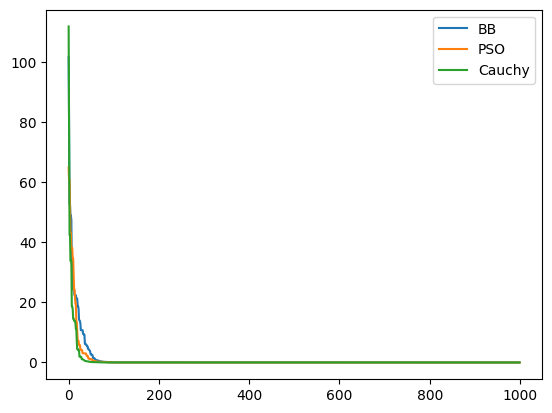

In [25]:
sphereCauchy = PSO(CauchyParticle, sphere, numGenerations, numDimensions, populationSize)
plt.plot(sphereBB["generations"], label="BB")
plt.plot(sphereCPSO["generations"], label="PSO")
plt.plot(sphereCauchy["generations"], label="Cauchy")
plt.legend(["BB", "PSO", "Cauchy"], loc='upper right')
plt.show()

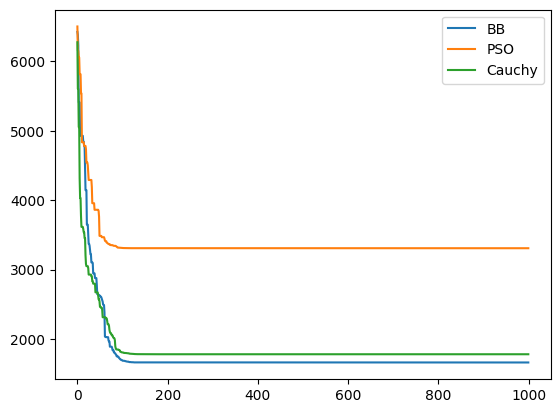

In [26]:
schwefelCauchy = PSO(CauchyParticle, schwefel, numGenerations, numDimensions, populationSize)
plt.plot(schwefelBB["generations"], label="BB")
plt.plot(schwefelCPSO["generations"], label="PSO")
plt.plot(schwefelCauchy["generations"], label="Cauchy")
plt.legend(["BB", "PSO", "Cauchy"], loc='upper right')
plt.show()

In [27]:
autoGrammar = """
<expr> ::=  <bbPso> | <cauchyPso> | <canonicalPso>

<bbPso> ::= PSO(BBParticle, fitnessFunc, numGenerations, numDimensions, <populationSize>)

<cauchyPso> ::= PSO(CauchyParticle, fitnessFunc, numGenerations, numDimensions, <populationSize>,  {"coolingFactor":<inertiaFactor>})

<canonicalPso> ::= PSO(Particle, fitnessFunc, numGenerations, numDimensions, <populationSize>,  {"inertiaFactor":<inertiaFactor>, "selfConfidence":<selfConfidence>, "swarmConfidence":<swarmConfidence>})
 
<inertiaFactor> ::= 0.<int><int> | 1

<selfConfidence> ::= 0.<int><int> | 1.<int><int> | 2

<swarmConfidence> ::= 0.<int><int> | 1.<int><int> | 2

<populationSize> ::= 10 | 20 | 30 | 40 | 50 | 60 | 70 | 80 | 90 | 100

<int> ::= 0 | 1 | 2 | 3 | 4 | 5 | 6 | 7 | 8 | 9
"""

In [28]:
optAutoPSOSchwefel = GE(
    grammar=autoGrammar,
    fitnessFunction=siSchwefel, 
    populationSize=50, 
    numGenerations=50, 
    mutationProbability=0.1, 
    crossoverProbability=0.5, 
    genotypeLength=10
).evolve("<expr>")

df = pd.DataFrame({
  "PSO": [schwefelCPSO["best"].fitness],
  "BB": [schwefelBB["best"].fitness],
  "Cauchy": [schwefelCauchy["best"].fitness],
  "AUTO W/ BB": [optPSOBBSchwefel[0].fitness],
  "AUTO ALL": [optAutoPSOSchwefel[0].fitness],
})
print(df) 

           PSO           BB       Cauchy   AUTO W/ BB    AUTO ALL
0  3308.522831  1664.205177  1782.643512  1428.845567  1167.68072


In [29]:
print(optAutoPSOSchwefel[0].phenotype)

PSO(BBParticle, fitnessFunc, numGenerations, numDimensions, 40)
